A demonstration of using contrastive divergence to train the parameters of a restricted Boltzmann machine.

### References and Materials

This notebook has made use of various textbooks, articles, and other resources with some particularly relevant examples given below.

**RBM and CD Background**:
- [1] K. Murphy. [*Probabilistic Machine Learning: Advanced Topics*.](https://probml.github.io/pml-book/book2.html) MIT Press, 2023.
- D. MacKay. *Information theory, inference and learning algorithms*. Cambridge University Press, 2003.
- Hastie, Trevor, et al. *The elements of statistical learning: data mining, inference, and prediction. Vol. 2*. New York: springer, 2009.

**Practical advice for training RBMs with the CD algorithm**:
- [2] G. Hinton. *A Practical Guide to Training Restricted Boltzmann Machines*. Tech. rep. U. Toronto, 2010.

**Code**:
- [gugarosa/learnenergy](https://github.com/gugarosa/learnergy)
- [yell/boltzmann-machines](https://github.com/yell/boltzmann-machines)
- [Ruslan Salakhutdinov Matlab code](http://www.cs.toronto.edu/~rsalakhu/DBM.html)

In [14]:
import os
import numpy as np
import jax
from jax import numpy as jnp
from jax import grad, jit, vmap, random

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

## Plotting functions

In [2]:
def plot_digit(img, label=None, ax=None):
    """Plot MNIST Digit."""
    if ax is None:
        fig, ax = plt.subplots()
    if img.ndim == 1:
        img = img.reshape(28, 28)
    ax.imshow(img.squeeze(), cmap="Greys_r")
    ax.axis("off")
    if label is not None:
        ax.set_title(f"Label:{label}", fontsize=10, pad=1.3)
    return ax


def grid_plot_imgs(imgs, dim=None, axs=None, labels=None, figsize=(5, 5)):
    """Plot a series of digits in a grid."""
    if dim is None:
        if axs is None:
            n_imgs = len(imgs)
            dim = np.sqrt(n_imgs)
            if not dim.is_integer():
                raise ValueError("If dim not specified `len(imgs)` must be a square number.")
            else:
                dim = int(dim)
        else:
            dim = len(axs)

    if axs is None:
        gridspec_kw = {"hspace": 0.05, "wspace": 0.05}
        if labels is not None:
            gridspec_kw["hspace"] = 0.25
        fig, axs = plt.subplots(dim, dim, figsize=figsize, gridspec_kw=gridspec_kw)

    for n in range(dim**2):
        img = imgs[n]
        row_idx = n // dim
        col_idx = n % dim
        axi = axs[row_idx, col_idx]
        if labels is not None:
            ax_label = labels[n]
        else:
            ax_label = None
        plot_digit(img, ax=axi, label=ax_label)

    return axs


def gridspec_plot_imgs(imgs, gs_base, title=None, dim=5):
    """Plot digits into a gridspec subgrid.

    Args:
        imgs - images to plot.
        gs_base - from `gridspec.GridSpec`
        title - subgrid title.

    Note that, in general, for this type of plotting it is considerably more
     simple to using `fig.subfigures()` however that requires matplotlib >=3.4
     which has some conflicts with the default colab setup as of the time of
     writing.
    """
    gs0 = gs_base.subgridspec(dim, dim)
    for i in range(dim):
        for j in range(dim):
            ax = fig.add_subplot(gs0[i, j])
            plot_digit(imgs[i * dim + j], ax=ax)
            if (i == 0) and (j == 2):
                if title is not None:
                    ax.set_title(title)

# Restricted Boltzmann Machines

Restricted Boltzmann Machines (RBMs) are a type of energy based model in which the connectivity of nodes is carefully designed to facilitate efficient sampling methods.
For details of RBMs see the sections on undirected graphical models (Section 4.3) and energy-based models (Chapter 23) in [1]. We reproduce here some of the relevant sampling equations which we will instrumenting below.

We will be considering RBMs with binary units in both the hidden, $\mathbf{h}$, and visible, $\mathbf{v}$, layers.

In general for Boltzmann machines with hidden units the probability of a particular state for the visible nodes is given by:
$$
P_{\theta}(\mathbf{v}) = \frac{\sum_{\mathbf{h}}\
 \exp(-\mathcal{E}\left(\mathbf{h},\mathbf{v},\theta)\right)}{Z(\theta)}
$$
where $\theta$ is the collection of parameters $\theta = (\mathbf{W}, \mathbf{a}, \mathbf{b})$:
- $\mathbf{W} \in \mathbb{R}^{N_{\mathrm{vis}} \times N_{\mathrm{hid}}}$
- $\mathbf{a} \in \mathbb{R}^{N_{\mathrm{hid}}}$
- $\mathbf{b} \in \mathbb{R}^{N_{\mathrm{vis}}}$

and the energy of state is given by:
$$
\mathcal{E}(\mathbf{h}, \mathbf{v}, \theta) = \mathbf{v}^\top \mathbf{W} \mathbf{h} + \mathbf{h}^\top \mathbf{a} + \mathbf{v}^\top \mathbf{b}.
$$

In restricted Boltzmann machines the hidden units are independent from one another conditional on the visible units, and vic versa. This means that it is straightforward to do conditional block-sampling of the state of the network. 

This independence structure has the property that when conditionally sampling, the probability that the $j$th hidden unit is active is,
$$
p(h_j = 1 | \mathbf{v}, \theta) = \sigma\left(b_j + \sum_i v_i w_{ij}\right),
$$
and probability that the $i$th visible unit is active is given by,
$$
p(v_i = 1 | \mathbf{h}, \theta) = \sigma\left(a_i + \sum_j h_j w_{ij}\right).
$$

The function $\sigma(\cdot)$ is the sigmoid function:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

## Contrastive Divergence

Contrastive divergence (CD) is the name for a family of algorithms used to perform approximate maximum likelihood training for RBMs.

Contrastive divergence approximates the gradient of the log probability of the data (our desired objective function) by intialising an MCMC chain on the data vector and sampling for a small number of steps. The insight behind CD is that even with a very small number of steps the process still provides gradient information which can be used to fit the model parameters.

Here we implement the CD1 algorithm which uses just a single round of Gibbs sampling.

For more details on the CD algorithm see [1] (Section 23.2.2).


In [3]:
def initialise_params(N_vis, N_hid, key):
    """Initialise the parameters.

    Args:
        N_vis - number of visible units.
        N_hid - number of hidden units.
        key - PRNG key.

    Returns:
        params - (W, a, b), Weights and biases for network.
    """
    W_key, a_key, b_key = random.split(key, 3)
    W = random.normal(W_key, (N_vis, N_hid)) * 0.01
    a = random.normal(a_key, (N_hid,)) * 0.01
    b = random.normal(b_key, (N_vis,)) * 0.01
    return (W, a, b)

In [4]:
@jit
def sample_hidden(vis, params, key):
    """Performs the hidden layer sampling, P(h|v;θ).

    Args:
        vis - state of the visible units.
        params - (W, a, b), Weights and biases for network.
        key - PRNG key.

    Returns:
        The probabilities and states of the hidden layer sampling.
    """
    W, a, _ = params
    activation = jnp.dot(vis, W) + a
    hid_probs = jax.nn.sigmoid(activation)
    hid_states = random.bernoulli(key, hid_probs).astype("int8")
    return hid_probs, hid_states


@jit
def sample_visible(hid, params, key):
    """Performs the visible layer sampling, P(v|h;θ).

    Args:
        hid -  state of the hidden units
        params - (W, a, b), Weights and biases for network.
        key - PRNG key.

    Returns:
        The probabilities and states of the visible layer sampling.
    """
    W, _, b = params
    activation = jnp.dot(hid, W.T) + b
    vis_probs = jax.nn.sigmoid(activation)
    vis_states = random.bernoulli(key, vis_probs).astype("int8")
    return vis_probs, vis_states


@jit
def CD1(vis_sample, params, key):
    """The one-step contrastive divergence algorithm.

    Can handle batches of training data.

    Args:
        vis_sample - sample of visible states from data.
        params - (W, a, b), Weights and biases for network.
        key - PRNG key.

    Returns:
        An estimate of the gradient of the log likelihood with respect
         to the parameters.
    """
    key, subkey = random.split(key)
    hid_prob0, hid_state0 = sample_hidden(vis_sample, params, subkey)
    key, subkey = random.split(key)
    vis_prob1, vis_state1 = sample_visible(hid_state0, params, subkey)
    key, subkey = random.split(key)
    # It would be more efficient here to not actual sample the unused states.
    hid_prob1, _ = sample_hidden(vis_state1, params, subkey)

    delta_W = jnp.einsum("...j,...k->...jk", vis_sample, hid_prob0) - jnp.einsum(
        "...j,...k->...jk", vis_state1, hid_prob1
    )
    delta_a = hid_prob0 - hid_prob1
    delta_b = vis_sample - vis_state1
    return (delta_W, delta_a, delta_b)

In [5]:
@jit
def reconstruct_vis(vis_sample, params, key):
    """Reconstruct the visible state from a conditional sample of the hidden
    units.

    Returns
       Reconstruction probabilities.
    """
    subkey1, subkey2 = random.split(key, 2)
    _, hid_state = sample_hidden(vis_sample, params, subkey1)
    vis_recon_prob, _ = sample_visible(hid_state, params, subkey2)
    return vis_recon_prob


@jit
def reconstruction_loss(vis_samples, params, key):
    """Calculate the L2 loss between a batch of visible samples and their
     reconstructions.

    Note this is a heuristic for evaluating training progress, not an objective
     function.
    """
    reconstructed_samples = reconstruct_vis(vis_samples, params, key)
    loss = optax.l2_loss(vis_samples.astype("float32"), reconstructed_samples).mean()
    return loss


@jit
def vis_free_energy(vis_state, params):
    """Calculate the free enery of a visible state.

     The free energy of a visible state is equal to the sum of the energies of
     all of the configurations of the total state (hidden + visible) which
     contain that visible state.

    Args:
        vis_state - state of the visible units.
        params - (W, a, b), Weights and biases for network.
        key - PRNG key.

    Returns:
        The free energy of the visible state.
    """
    W, a, b = params
    activation = jnp.dot(vis_state, W) + a
    return -jnp.dot(vis_state, b) - jnp.sum(jax.nn.softplus(activation))


@jit
def free_energy_gap(vis_train_samples, vis_test_samples, params):
    """Calculate the average difference in free energies between test and train
     data.

     The free energy gap can be used to evaluate overfitting. If the model
     starts to overfit the training data the free energy gap will start to
     become increasingly negative.

    Args:
        vis_train_samples - samples of visible states from training data.
        vis_test_samples - samples of visible states from validation data.
        params - (W, a, b), Weights and biases for network.

    Returns:
        The difference between the test and validation free energies.
    """
    train_FE = vmap(vis_free_energy, (0, None))(vis_train_samples, params)
    test_FE = vmap(vis_free_energy, (0, None))(vis_test_samples, params)
    return train_FE.mean() - test_FE.mean()


@jit
def evaluate_params(train_samples, test_samples, params, key):
    """Calculate performance measures of parameters."""
    train_key, test_key = random.split(key)
    train_recon_loss = reconstruction_loss(train_samples, params, train_key)
    test_recon_loss = reconstruction_loss(test_samples, params, test_key)
    FE_gap = free_energy_gap(train_samples, test_samples, params)
    return train_recon_loss, test_recon_loss, FE_gap

### Load MNIST

In [6]:
def preprocess_images(images):
    images = images.reshape((len(images), -1))
    return jnp.array(images > (255 / 2), dtype="float32")


def load_mnist(split):
    images, labels = tfds.as_numpy(tfds.load("mnist", split=split, batch_size=-1, as_supervised=True))
    procced_images = preprocess_images(images)
    return procced_images, labels

In [7]:
mnist_train_imgs, mnist_train_labels = load_mnist("train")
mnist_test_imgs, mnist_test_labels = load_mnist("test")

2022-07-25 18:29:42.353932: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Training with optax

In [8]:
def train_RBM(params, train_data, optimizer, key, eval_samples, n_epochs=5, batch_size=20):
    """Optimize parameters of RBM using the CD1 algoritm."""

    @jit
    def batch_step(params, opt_state, batch, key):
        grads = jax.tree_map(lambda x: x.mean(0), CD1(batch, params, key))
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = jax.tree_map(lambda p, u: p - u, params, updates)
        return params, opt_state

    opt_state = optimizer.init(params)
    metric_list = []
    param_list = [params]
    n_batches = len(train_data) // batch_size

    for _ in range(n_epochs):
        key, subkey = random.split(key)
        perms = random.permutation(subkey, len(mnist_train_imgs))
        perms = perms[: batch_size * n_batches]  # Skip incomplete batch
        perms = perms.reshape((n_batches, -1))
        for n, perm in enumerate(perms):
            batch = mnist_train_imgs[perm, ...]
            key, subkey = random.split(key)
            params, opt_state = batch_step(params, opt_state, batch, subkey)
            if n % 200 == 0:
                key, eval_key = random.split(key)
                batch_metrics = evaluate_params(*eval_samples, params, eval_key)
                metric_list.append(batch_metrics)
        param_list.append(params)

    return params, metric_list, param_list

In [9]:
# In practice you can use many more than 100 hidden units, up to 1000-2000.
#  A small number is chosen here so that training is fast.
N_vis, N_hid = mnist_train_imgs.shape[-1], 100
key = random.PRNGKey(111)
key, subkey = random.split(key)
init_params = initialise_params(N_vis, N_hid, subkey)

optimizer = optax.sgd(learning_rate=0.05, momentum=0.9)
eval_samples = (mnist_train_imgs[:1000], mnist_test_imgs[:1000])

params, metric_list, param_list = train_RBM(init_params, mnist_train_imgs, optimizer, key, eval_samples)

### Evaluating Training

The **reconstruction loss** is a *heuristic* measure of training performance. It measures a combination of two effects:

1. The difference between the equilibrium distribution of the RBM and the empirical distribution of the data.

2. The mixing rate of the Gibbs sampling.

The first of these effects tends to be what we care about however it is impossible to distinguish it from the second [2].

The objective function which contrastive divergence optimizes is the probability that the RBM assigns to the dataset. For the reasons outlined above we cannot calculate this directly because it requires knowledge of the partition function.

We can however compare the average **free energy** between two different sets of data. In the comparison the partition function cancel out. Hinton [2] suggests using this comparison as a measure of overfitting. If the model is not overfitting the values should be approximately the same. As the model starts to overfit the free energy of the validation data will increase with respect to the training data so the difference between the two values will become increasingly negative.


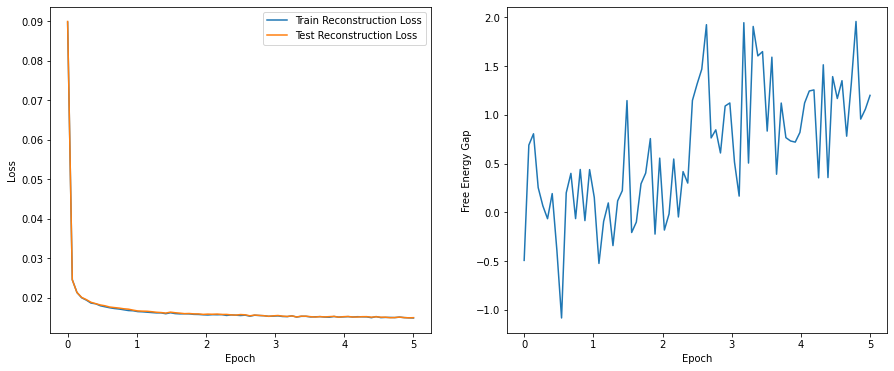

In [10]:
train_recon_loss, test_recon_loss, FE_gap = list(zip(*metric_list))
epoch_progress = np.linspace(0, 5, len(train_recon_loss))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(epoch_progress, train_recon_loss, label="Train Reconstruction Loss")
ax1.plot(epoch_progress, test_recon_loss, label="Test Reconstruction Loss")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.plot(epoch_progress, FE_gap)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Free Energy Gap");

In [13]:
os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures"

In [15]:
pml.latexify(width_scale_factor=1, fig_height=2)

saving image to figures/rbm_mnist_samples_latexified.pdf
Figure size: [6. 2.]


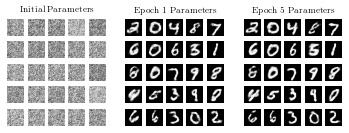

In [30]:
vis_data_samples = mnist_test_imgs[:25]

fig = plt.figure(figsize=None)  # (15, 5))
gs_bases = gridspec.GridSpec(1, 3, figure=fig)
recon_params = (param_list[0], param_list[1], param_list[-1])
subfig_titles = ("Initial", "Epoch 1", "Epoch 5")

key, subkey = random.split(key)

for gs_base, epoch_param, sf_title in zip(gs_bases, recon_params, subfig_titles):
    # Use the same subkey for all parameter sets.
    vis_recon_probs = reconstruct_vis(vis_data_samples, epoch_param, subkey)
    title = f"{sf_title} Parameters"
    gridspec_plot_imgs(vis_recon_probs, gs_base, title)

# fig.suptitle("Reconstruction Samples", fontsize=20);

# plt.savefig("rbm_mnist_samples_latexified.pdf", pad_inches=0)
pml.savefig("rbm_mnist_samples_latexified", pad_inches=0, tight_layout=False)

## Classification

While Boltzmann Machines are generative models they can be adapted to be used for classification and other discriminative tasks.

Here we use RBM to transform a sample image into the hidden representation and then use this as input to a **logistic regression classifier**.

This classification is more accurate than when using the raw image data as input. Furthermore, the hidden the accuracy of classification increases as the training time increases.

Alternatively, a RBM can made to include a set of visible units which encode the class label. Classification is then performed by clamping each of the class units in turn along with the test sample. The unit that gives the lowest free energy is the chosen class [2].

In [13]:
class RBM_LogReg:
    """
    Perform logistic regression on samples transformed to RBM hidden
     representation with `params`.
    """

    def __init__(self, params):
        self.params = params
        self.LR = LogisticRegression(solver="saga", tol=0.1)

    def _transform(self, samples):
        W, a, _ = self.params
        activation = jnp.dot(samples, W) + a
        hidden_probs = jax.nn.sigmoid(activation)
        return hidden_probs

    def fit(self, train_samples, train_labels):
        transformed_samples = self._transform(train_samples)
        self.LR.fit(transformed_samples, train_labels)

    def score(self, test_samples, test_labels):
        transformed_samples = self._transform(test_samples)
        return self.LR.score(transformed_samples, test_labels)

    def predict(self, test_samples):
        transformed_samples = self._transform(test_samples)
        return self.LR.predict(transformed_samples)

    def reconstruct_samples(self, samples, key):
        return reconstruct_vis(samples, self.params, key)

In [14]:
train_data = (mnist_train_imgs, mnist_train_labels)
test_data = (mnist_test_imgs, mnist_test_labels)

# Train LR classifier on the raw pixel data for comparison.
LR_raw = LogisticRegression(solver="saga", tol=0.1)
LR_raw.fit(*train_data)

# LR classifier trained on hidden representations after 1 Epoch of training.
rbm_lr1 = RBM_LogReg(param_list[1])
rbm_lr1.fit(*train_data)

# LR classifier trained on hidden representations after 5 Epochs of training.
rbm_lr5 = RBM_LogReg(param_list[-1])
rbm_lr5.fit(*train_data)

print("Logistic Regression Accuracy:")
print(f"\tRaw Data: {LR_raw.score(*test_data)}")
print(f"\tHidden Units Epoch-1: {rbm_lr1.score(*test_data)}")
print(f"\tHidden Units Epoch-5: {rbm_lr5.score(*test_data)}")

Logistic Regression Accuracy:
	Raw Data: 0.9171
	Hidden Units Epoch-1: 0.9223
	Hidden Units Epoch-5: 0.9317


The increase in accuracy here is modest because of the small number of hidden units. When 1000 hidden units are used the Epoch-5 accuracy approaches 97.5%.

In [15]:
class1_correct = rbm_lr1.predict(mnist_test_imgs) == mnist_test_labels
class5_correct = rbm_lr5.predict(mnist_test_imgs) == mnist_test_labels

diff_class_img_idxs = np.where(class5_correct & ~class1_correct)[0]
print(f"There are {len(diff_class_img_idxs)} images which were correctly labelled after >1 Epochs of training.")

There are 382 images which were correctly labelled after >1 Epochs of training.


We can explore the quality of the learned hidden tranformation by inspecting reconstructions of these test images.

You can explore this by choosing different subsets of images in the cell below:

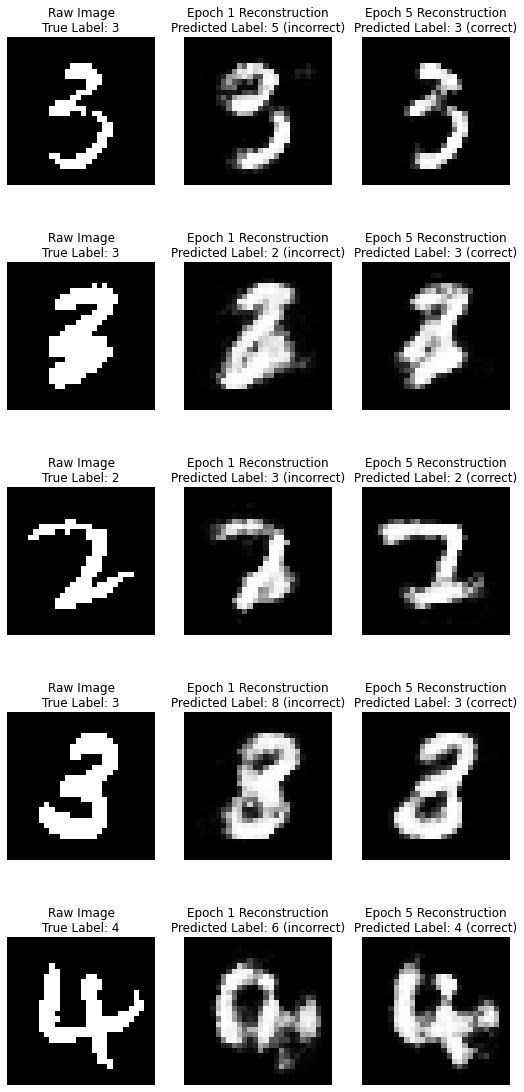

In [17]:
key = random.PRNGKey(100)

# Try out different subsets of img indices.
idx_list = diff_class_img_idxs[100:]

n_rows = 5
fig, axs = plt.subplots(n_rows, 3, figsize=(9, 20))

for img_idx, ax_row in zip(idx_list, axs):
    ax1, ax2, ax3 = ax_row

    img = mnist_test_imgs[img_idx]

    plot_digit(img, ax=ax1)
    true_label = mnist_test_labels[img_idx]
    ax1.set_title(f"Raw Image\nTrue Label: {true_label}")

    epoch1_recon = rbm_lr1.reconstruct_samples(img, key)
    plot_digit(epoch1_recon, ax=ax2)
    hid1_label = rbm_lr1.predict(img[None, :])[0]
    ax2.set_title(f"Epoch 1 Reconstruction\nPredicted Label: {hid1_label} (incorrect)")

    epoch5_recon = rbm_lr5.reconstruct_samples(img, key)
    hid5_label = rbm_lr5.predict(img[None, :])[0]
    plot_digit(epoch5_recon, ax=ax3)
    ax3.set_title(f"Epoch 5 Reconstruction\nPredicted Label: {hid5_label} (correct)");